Data file size analysis to infer completeness of data set for each sample in GENEWIZ project 30-317737003

In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import synapseclient
import synapseutils
import re
import io
import subprocess
import os.path
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
syn = synapseclient.login()

Welcome, Attila Jones!



### Chaggai's table
for conversion between GENEWIZ *Sample ID* and CMC *Individual ID*

In [2]:
chaggai = pd.read_csv('/home/attila/projects/bsm/tables/samples-from-Chaggai.csv', index_col='GENEWIZ_serialn')

### Data report by GENEWIZ

In [3]:
def get_gw_report(fname='genewiz-report.csv'):
    wdir = '/home/attila/projects/bsm/results/2020-05-20-genewiz-data-sizes/'
    genewiz_report = pd.read_csv(wdir + os.path.sep + fname, index_col='Sample ID')
    genewiz_report = genewiz_report.loc[chaggai.index, :]
    genewiz_report['Yield (Gbases)'] = genewiz_report['Yield (Mbases)'] / 1e3
    genewiz_report['GENEWIZ_serialn'] = genewiz_report.index
    genewiz_report.index = [y + '_NeuN_pl' for y in chaggai['CMC_simple_id']]
    genewiz_report['GENEWIZ_short_serialn'] = [re.sub('^([A-H])-.*$', '\\1', y) for y in genewiz_report['GENEWIZ_serialn']]
    gwi = list(genewiz_report.index)
    gwi.sort()
    genewiz_report = genewiz_report.loc[gwi, :]
    return(genewiz_report)

genewiz_report = get_gw_report('genewiz-report.csv')
nofailed = get_gw_report('genewiz-report-without-failed.csv')
genewiz_report['# Reads w/o failed'] = nofailed['# Reads']
genewiz_report['Yield (Gbases) w/o failed'] = nofailed['Yield (Gbases)']

In [22]:
dict = '/big/data/refgenome/GRCh37/dna/hs37d5.dict'
l1 = ['sed', '-n', '/^@SQ/ {s/[SL]N://g; p}; /\tY\t/ q', dict]
p1 = subprocess.run(l1, capture_output=True)
l2 = ['cut', '-f', '2,3']
p2 = subprocess.run(l2, input=p1.stdout, capture_output=True)
chr_len = pd.read_csv(io.BytesIO(p2.stdout), sep='\t', names=['chr', 'length'], index_col='chr')
chr_len.sum()
genewiz_report['Coverage'] = genewiz_report['Yield (Mbases)'] / np.float(chr_len.sum()) * 1e6
genewiz_report.to_csv('/home/attila/projects/bsm/results/2020-05-20-genewiz-data-sizes/coverage.csv')

The samples where the failed flowcell makes a difference in terms of yield

In [5]:
genewiz_report.loc[genewiz_report['Yield (Gbases)'] != genewiz_report['Yield (Gbases) w/o failed'], 'GENEWIZ_serialn']

MSSM_063_NeuN_pl    84
MSSM_162_NeuN_pl    60
MSSM_192_NeuN_pl    27
MSSM_269_NeuN_pl    14
PITT_098_NeuN_pl    38
PITT_117_NeuN_pl     1
Name: GENEWIZ_serialn, dtype: object

### FASTQ sizes

In [6]:
def get_fastqs(s3_folder='30-317737003/'):
    p1 = subprocess.run(['aws', 's3', 'ls', 's3://chesslab-bsmn/GENEWIZ/' + s3_folder], capture_output=True)
    p2 = subprocess.run(['tr', '--squeeze', '" "', ','], input=p1.stdout, capture_output=True)
    fastqs = pd.read_csv(io.StringIO(p2.stdout.decode('utf-8')), names=['Date', 'Time', 'FASTQ size B', 'Filename'], index_col='Filename')
    fastqs = fastqs.loc[[i for i in fastqs.index if re.match('.*\.fastq\.gz', i)], :] # retain only fastq.gz files
    fastqs['FASTQ size GiB'] = fastqs['FASTQ size B'] / 2 ** 30
    genewiz_serialn = [re.sub('^([^_]+)_.*$', '\\1', i) for i in fastqs.index]
    fastqs['Sample'] = [i + '_NeuN_pl' for i in list(chaggai.loc[genewiz_serialn, 'CMC_simple_id'])]
    return(fastqs)

In [7]:
fastqs = get_fastqs('30-317737003/')
fastqs_12 = pd.concat([fastqs, get_fastqs('30-317737003_12_lanes/')], axis=0)

In [8]:
def get_unmapped(fastqs): 
    unmapped = fastqs.groupby('Sample').sum()['FASTQ size GiB']
    ix = list(unmapped.index)
    ix.sort()
    unmapped = unmapped.loc[ix]
    return(unmapped)

In [9]:
unmapped = get_unmapped(fastqs)
unmapped_12 = get_unmapped(fastqs_12)

In [10]:
unmapped.head()

Sample
MSSM_027_NeuN_pl    366.533664
MSSM_055_NeuN_pl    417.480726
MSSM_063_NeuN_pl     33.275386
MSSM_069_NeuN_pl     86.257381
MSSM_097_NeuN_pl    651.228232
Name: FASTQ size GiB, dtype: float64

### Putting it together

In [11]:
genewiz = genewiz_report.loc[unmapped.index, :]
genewiz['FASTQ size GiB'] = unmapped
genewiz['FASTQ size GiB +12 lanes'] = unmapped_12

### Intermezzo: coverage

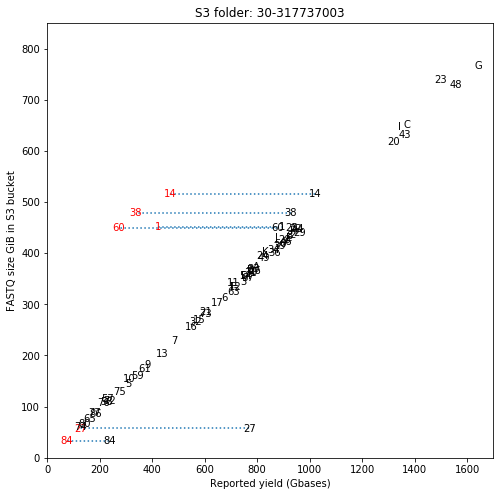

In [12]:
%matplotlib inline
def yield_vs_fastqsize(Y='FASTQ size GiB', X1='Yield (Gbases)', X2=None, title='S3 folder: 30-317737003'):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xlim([0, 1700])
    ax.set_ylim([0, 850])
    ax.set_xlabel('Reported yield (Gbases)')
    ax.set_ylabel('FASTQ size GiB in S3 bucket')
    ax.set_title(title)
    for i in range(genewiz.shape[0]):
        x1 = genewiz[X1][i]
        y = genewiz[Y][i]
        s = genewiz['GENEWIZ_short_serialn'][i]
        if X2 is not None:
            x2 = genewiz[X2][i]
            if x1 != x2:
                ax.text(x2, y, s=s, color='r', ha='center', va='center')
                line = matplotlib.lines.Line2D([x1, x2], [y, y], linestyle=':')
                ax.add_line(line)
        ax.text(x1, y, s=s, ha='center', va='center')

yield_vs_fastqsize(Y='FASTQ size GiB', X1='Yield (Gbases)', X2='Yield (Gbases) w/o failed', title='S3 folder: 30-317737003')

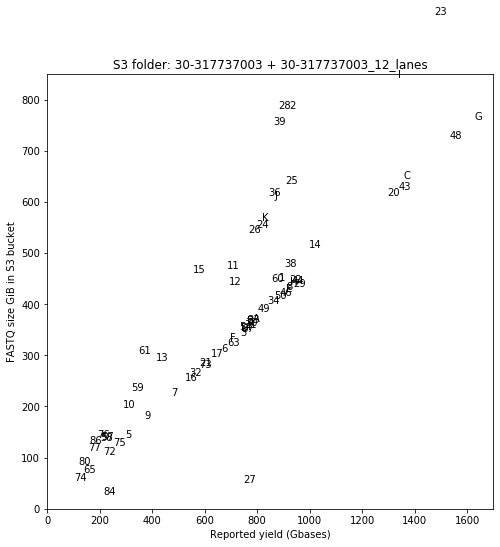

In [13]:
yield_vs_fastqsize(Y='FASTQ size GiB +12 lanes', title='S3 folder: 30-317737003 + 30-317737003_12_lanes')

In [14]:
outliers = ['65', '5', 'F', 'D', 'B', 'C', '84', '1', '60', '38', '14', '27']

In [15]:
genewiz.loc[genewiz.isin({'GENEWIZ_short_serialn': outliers})['GENEWIZ_short_serialn'], ['GENEWIZ_serialn', 'GENEWIZ_short_serialn']]

,GENEWIZ_serialn,GENEWIZ_short_serialn
Sample,,
MSSM_063_NeuN_pl,84,84
MSSM_097_NeuN_pl,C-MSSM-1199,C
MSSM_162_NeuN_pl,60,60
MSSM_192_NeuN_pl,27,27
MSSM_201_NeuN_pl,65,65
MSSM_269_NeuN_pl,14,14
MSSM_297_NeuN_pl,B-MSSM-1172,B
MSSM_308_NeuN_pl,5,5
MSSM_362_NeuN_pl,F-MSSM-1346,F


### CRAM sizes

In [16]:
scratch = list(synapseutils.walk(syn, 'syn20735395'))[0][2] # get file list
scratch = [y for y in scratch if re.match('^.*\.cram$', y[0])] # retain only .cram files and remove everything else like .crai files
entities = [syn.get(y[1], downloadFile=False) for y in scratch]

In [17]:
def entity2df(e):
    '''given Synapse entity e create one-lined data frame'''
    simple_id = re.sub('_(muscle|NeuN_pl|NeuN_mn).*$', '', e.name)
    indiv_id = 'CMC_' + simple_id
    d = dict()
    d['Individual ID'] = indiv_id
    d['Tissue'] = re.sub('^.*(muscle|NeuN_pl|NeuN_mn).*$', '\\1', e.name)
    d['File name'] = e.name
    d['Modification time'] = e.modifiedOn
    users = {'3388274': '@cmolitor', '3340241': '@taejeong', '3338602': '@attilajones'}
    d['Created by'] = users[e.createdBy]
    d['Modified by'] = users[e.modifiedBy]
    d['CRAM size GiB'] = e._file_handle.contentSize / 2 ** 30
    e._file_handle.contentSize
    df = pd.DataFrame(d, index=[e.name.replace('.cram', '')])
    return(df)

mapped = pd.concat([entity2df(e) for e in entities])
mapped.head()

TypeError: 'str' object is not callable

In [ ]:
shared_samples = list(set(unmapped.index).intersection(set(mapped.index)))
shared_samples.sort()
combined = pd.concat([unmapped.loc[shared_samples], mapped.loc[shared_samples, 'CRAM size GiB']], axis=1)

In [ ]:
%connect_info